<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis (PCA)
Principal Component Analysis is an unsupervised dimensionality reduction technique used to transform a high-dimensional dataset into a lower-dimensional space while retaining the most important patterns and variations in the data. The algorithm identifies orthogonal axes, known as principal components, that capture the maximum variance in the data. These components are ordered by their significance, with the first component explaining the most variance and subsequent components explaining the remaining variance in decreasing order. By projecting the data onto the selected principal components, PCA effectively reduces its dimensionality (number of features), making it easier to visualize and analyze while preserving essential information.






### Import libraries and initialize random generator

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphing
np.random.seed(0)

### Read data from CSV
We will use the wholesale customers dataset. The data set includes the annual spending amount on 8 product categories of 440 customers. We will try to group these customers into different clusters, which in real life may represent groups such as individual buyers, business owners, tourists ... (these are just examples)

https://archive.ics.uci.edu/dataset/292/wholesale+customers

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/TrainingByPackt/Data-Science-with-Python/master/Chapter01/Data/Wholesale%20customers%20data.csv")
display(dataset)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [21]:
print(dataset.shape)
n_samples = dataset.shape[0]
n_features = dataset.shape[1]

(440, 8)


In [8]:
# Convert the dataset into a numpy matrix
X = dataset.to_numpy()
display(X)

array([[    2,     3, 12669, ...,   214,  2674,  1338],
       [    2,     3,  7057, ...,  1762,  3293,  1776],
       [    2,     3,  6353, ...,  2405,  3516,  7844],
       ...,
       [    2,     3, 14531, ...,   437, 14841,  1867],
       [    1,     3, 10290, ...,  1038,   168,  2125],
       [    1,     3,  2787, ...,    65,   477,    52]])

### Standardizing dataset values
We can standardize features by removing the mean and scaling to unit variance, so all features are treated equally.

In [10]:
def mean(x):
    return sum(x)/len(x)

def std(x):
    return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

dataset_standardized = ( X - mean(X) )  /  std(X)
display(dataset_standardized)

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

### Covariance matrix

In statistics, the covariance matrix is a fundamental concept used to understand the relationships between multiple variables in a dataset. It provides a measure of how two variables vary together. The covariance matrix is a square matrix where each element represents the covariance between two variables.

Let's assume we have a dataset with 'n' observations and 'm' variables. The covariance matrix, denoted as $\mathbf{C}$, is an $m \times m$ matrix, where the $(i,j)$th element represents the covariance between variables $X_i$ and $X_j$:

$$
\mathbf{C} = \begin{bmatrix}
\text{cov}(X_1, X_1) & \text{cov}(X_1, X_2) & \dots & \text{cov}(X_1, X_m) \\
\text{cov}(X_2, X_1) & \text{cov}(X_2, X_2) & \dots & \text{cov}(X_2, X_m) \\
\vdots & \vdots & \ddots & \vdots \\
\text{cov}(X_m, X_1) & \text{cov}(X_m, X_2) & \dots & \text{cov}(X_m, X_m) \\
\end{bmatrix}
$$

The diagonal elements of the covariance matrix ($C_{ii}$) represent the variance of each variable, and the off-diagonal elements ($C_{ij}$ where $i \neq j$) represent the covariances between different pairs of variables.

The covariance between two variables, $X_i$ and $X_j$, is given by the following formula:

$$
\text{cov}(X_i, X_j) = \frac{1}{n-1} \sum_{k=1}^{n} (X_{ki} - \bar{X}_i) \cdot (X_{kj} - \bar{X}_j)
$$

Where:
- $X_{ki}$ and $X_{kj}$ are the values of variable $X_i$ and $X_j$ for the $k$th observation, respectively.
- $\bar{X}_i$ and $\bar{X}_j$ are the means of variables $X_i$ and $X_j$ across all observations.

The matrix can be computed using the following:
$$\mathbf{C} = \frac{X^T \cdot X}{n-1}$$


In [12]:
def covariance(x):
    n = x.shape[0]
    return (x.T @ x)/(n-1)

cov_mat = covariance(dataset_standardized)

### Finding eigenvectors and eigenvalues of the covariance matrix (eigendecomposition of covariance matrix)


In [14]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [3.10707136 1.79404441 1.0140786  0.06293318 0.28176643 0.74007428
 0.46035462 0.55790035]
Eigenvectors 
 [[-4.28291564e-01 -2.04698855e-01 -8.29798863e-02  1.93353734e-02
   1.39899044e-01  2.96441646e-02 -8.63506696e-01  3.62058452e-02]
 [-2.47260253e-02  4.31296430e-02 -9.82500889e-01 -1.54504484e-03
  -2.32799384e-02  7.78446249e-02  8.97647905e-02 -1.32508923e-01]
 [ 2.53194580e-02  5.13444679e-01 -8.89509074e-02 -3.38511136e-02
  -2.71736934e-02 -7.98475924e-01 -1.47474736e-01  2.58116864e-01]
 [-4.74409947e-01  2.05540611e-01  2.57510842e-02 -3.92913471e-02
   7.89020414e-01  5.40220237e-02  3.15932560e-01  7.20857633e-02]
 [-5.36329145e-01 -8.71761988e-03  4.53143572e-02  7.15984124e-01
  -3.53064294e-01 -1.21586244e-01  2.13698887e-01 -1.11729898e-01]
 [ 2.99745579e-02  5.92745252e-01  1.22156522e-01 -1.29832249e-02
  -5.33679297e-03  1.61316883e-01 -1.94359931e-01 -7.54212444e-01]
 [-5.23906297e-01 -1.21083091e-01  4.74814388e-02 -6.91672189e-01
  -3.71374310e-0

In [15]:
# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [3.10707136 1.79404441 1.0140786  0.06293318 0.28176643 0.74007428
 0.46035462 0.55790035]
Eigenvectors 
 [[ 4.28291564e-01  2.47260253e-02 -2.53194580e-02  4.74409947e-01
   5.36329145e-01 -2.99745579e-02  5.23906297e-01  1.64996527e-01]
 [-2.04698855e-01  4.31296430e-02  5.13444679e-01  2.05540611e-01
  -8.71761988e-03  5.92745252e-01 -1.21083091e-01  5.33180819e-01]
 [ 8.29798863e-02  9.82500889e-01  8.89509074e-02 -2.57510842e-02
  -4.53143572e-02 -1.22156522e-01 -4.74814388e-02  9.30199386e-04]
 [ 1.93353734e-02 -1.54504484e-03 -3.38511136e-02 -3.92913471e-02
   7.15984124e-01 -1.29832249e-02 -6.91672189e-01 -7.56425871e-02]
 [ 1.39899044e-01 -2.32799384e-02 -2.71736934e-02  7.89020414e-01
  -3.53064294e-01 -5.33679297e-03 -3.71374310e-01 -3.06582655e-01]
 [-2.96441646e-02 -7.78446249e-02  7.98475924e-01 -5.40220237e-02
   1.21586244e-01 -1.61316883e-01  1.51012112e-01 -5.37557669e-01]
 [ 8.63506696e-01 -8.97647905e-02  1.47474736e-01 -3.15932560e-01
  -2.13698887e-0

### Sorting the eigenvectors and eigenvalues
Here, we sort eigenvalues in descending order.

In [17]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

for e in eig_pairs:
  print(e)


(3.107071358742731, array([ 0.42829156,  0.02472603, -0.02531946,  0.47440995,  0.53632914,
       -0.02997456,  0.5239063 ,  0.16499653]))
(1.7940444097416113, array([-0.20469886,  0.04312964,  0.51344468,  0.20554061, -0.00871762,
        0.59274525, -0.12108309,  0.53318082]))
(1.0140786002760043, array([ 8.29798863e-02,  9.82500889e-01,  8.89509074e-02, -2.57510842e-02,
       -4.53143572e-02, -1.22156522e-01, -4.74814388e-02,  9.30199386e-04]))
(0.740074284503021, array([-0.02964416, -0.07784462,  0.79847592, -0.05402202,  0.12158624,
       -0.16131688,  0.15101211, -0.53755767]))
(0.5579003530181726, array([-0.03620585,  0.13250892, -0.25811686, -0.07208576,  0.1117299 ,
        0.75421244,  0.17650264, -0.54482721]))
(0.46035461531450866, array([ 0.8635067 , -0.08976479,  0.14747474, -0.31593256, -0.21369889,
        0.19435993, -0.19575356,  0.05453289]))
(0.28176643281654057, array([ 0.13989904, -0.02327994, -0.02717369,  0.78902041, -0.35306429,
       -0.00533679, -0.371374

### Explained variance
We can graph out the explained variance of each principle component.

Explained variance: [38.75012291 22.37458795 12.64717345  9.22990372  6.95790497  5.74135444
  3.51407568  0.78487688]


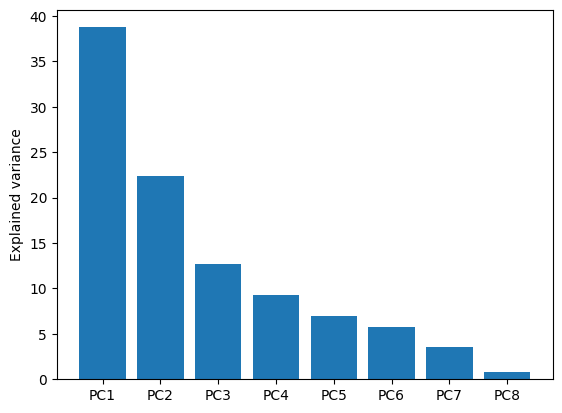

In [31]:
eig_vals_total = sum(eig_vals)
# convert the eigenvalues to percentage of the total sum of all eigenvalues
explained_variance = eig_vals_sorted/eig_vals_total * 100

print('Explained variance:',explained_variance)

plt.bar(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],explained_variance)
plt.ylabel('Explained variance');

we now graph out the cumulative explained variance of the 8 principal components. From the graph, we can see that just 3 principal components accounts for 73% of the explained variance.

Cumulative explained variance: [ 38.75012291  61.12471086  73.77188431  83.00178803  89.959693
  95.70104744  99.21512312 100.        ]


Text(0, 0.5, 'Cumulative explained variance')

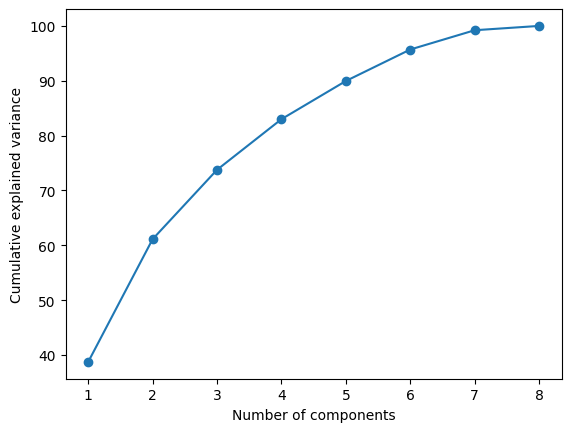

In [34]:
cumulative_explained_variance = np.cumsum(explained_variance)
print('Cumulative explained variance:',cumulative_explained_variance)

plt.plot([1,2,3,4,5,6,7,8], cumulative_explained_variance, '-o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

### Dimension reduction
we choose the top k eigenvectors where  k is the number of dimensions of the new feature subspace to reduce the dimension (number of features) in our dataset.

In [39]:
# Select top k eigenvectors
k = 2
W = eig_vecs_sorted[:k, :] # Projection matrix

print(W)

[[ 0.42829156  0.02472603 -0.02531946  0.47440995  0.53632914 -0.02997456
   0.5239063   0.16499653]
 [-0.20469886  0.04312964  0.51344468  0.20554061 -0.00871762  0.59274525
  -0.12108309  0.53318082]]


### Project the dataset
With the transformation matrix, we can now transform the dataset using the projection matrix  W to obtain a k-dimensional feature subspace.

In [ ]:
X_proj = dataset_standardized.dot(W.T)
print(X_proj.shape)

### Visualization of the projection

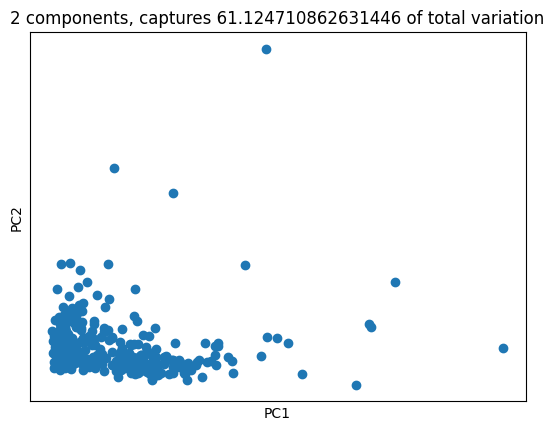

In [43]:
plt.scatter(X_proj[:, 0], X_proj[:, 1])
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {} of total variation'.format(cumulative_explained_variance[1]))
plt.show()

### Comparison of cluster (before vs. after PCA)

In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(dataset_standardized)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# Calculate the WCSS (Within-Cluster Sum of Squares)
wcss = np.sum((dataset_standardized - cluster_centers[cluster_labels]) ** 2)
print("WCSS:", wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


WCSS: 1548.8659343652666


In [54]:
k = 5
W = eig_vecs_sorted[:k, :] # Projection matrix
dataset_proj = dataset_standardized.dot(W.T)


kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(dataset_proj)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# Calculate the WCSS (Within-Cluster Sum of Squares)
wcss = np.sum((dataset_proj - cluster_centers[cluster_labels]) ** 2)
print("WCSS:", wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


WCSS: 1314.6987546155838


## References
- https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/
- https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
- https://www.youtube.com/watch?v=FgakZw6K1QQ
- https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering
- https://www.kaggle.com/code/kashnitsky/a7-demo-unsupervised-learning/notebook